# Get Data

In [1]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [2]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# Creating Datasets and DataLoaders

In [5]:
import data_setup

### Creating a transform for `torchvision.models` (manual creation)

In [4]:
from torchvision import transforms

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32,
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7efe58d75f60>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for `torchvision.models` (auto creation)

In [7]:
from torchvision.models import EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7efe6a148760>,
 ['pizza', 'steak', 'sushi'])

In [19]:
sample_batch_image, sample_batch_label = next(iter(train_dataloader))
sample_batch_image.shape, sample_batch_label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [23]:
sample_image = sample_batch_image[0]
sample_label = sample_batch_label[0]
sample_image.shape, sample_label

(torch.Size([3, 224, 224]), tensor(1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'steak')

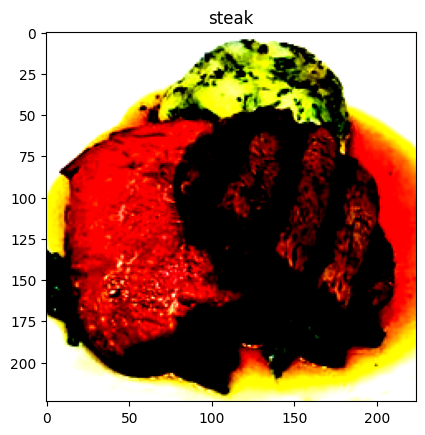

In [28]:
import matplotlib.pyplot as plt
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(class_names[sample_label])

# Getting a pretrained model

In [11]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [40]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
from torchinfo import summary

def get_model_summary(model, input_size):
    return summary(model=model, input_size=input_size,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])
    
get_model_summary(model=model, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### Freezing the base model and changing the output layer to suit our needs

In [43]:
for param in model.features.parameters():
    param.requires_grad = False

In [44]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [45]:
# Changing the classifier layer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape,
              bias=True)
).to(device)

get_model_summary(model=model, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# Train model

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [47]:
import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.8537 | test_acc: 0.7383
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7179 | test_acc: 0.8828
Epoch: 3 | train_loss: 0.7647 | train_acc: 0.7930 | test_loss: 0.6404 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.7108 | train_acc: 0.7539 | test_loss: 0.5480 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.5107 | test_acc: 0.9102
[INFO] Total training time: 6.521 seconds


In [48]:
results

{'train_loss': [1.092382088303566,
  0.8717352598905563,
  0.7647470682859421,
  0.7108385264873505,
  0.6254858784377575],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.85373904556036,
  0.7178786545991898,
  0.6403866857290268,
  0.5480046644806862,
  0.5106839053332806],
 'test_acc': [0.73828125, 0.8828125, 0.90625, 0.9375, 0.91015625]}

# Evaluate model 

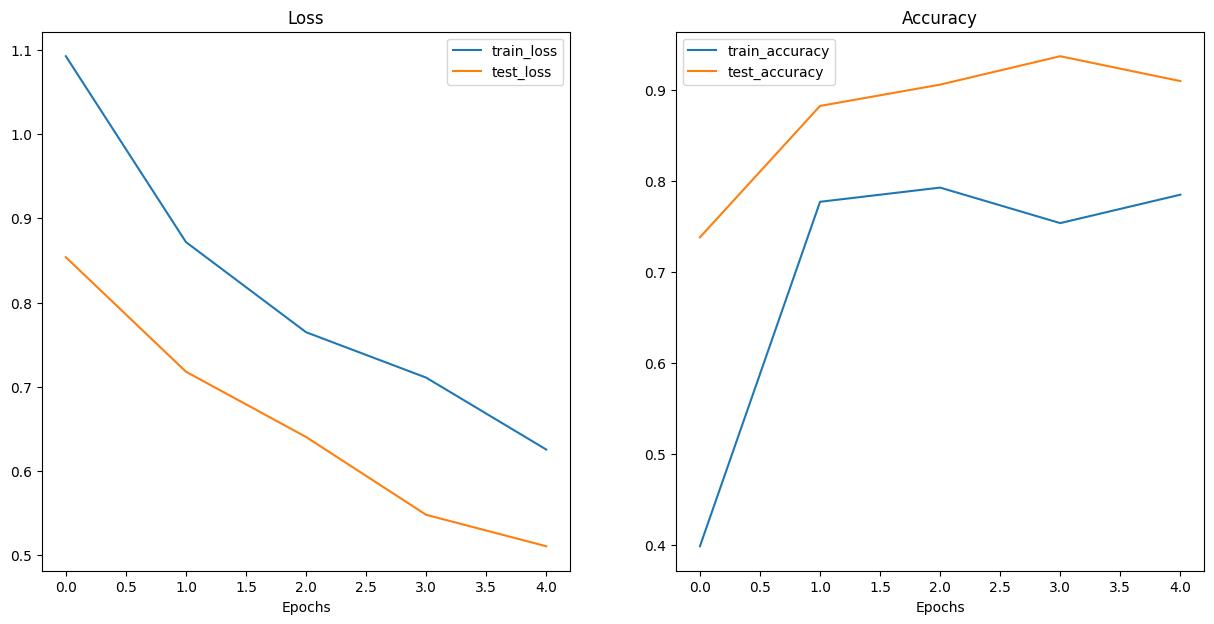

In [49]:
from utils import plot_loss_curves

plot_loss_curves(results=results)

## Making predictions on images from test set

In [64]:
from utils import pred_and_plot_image

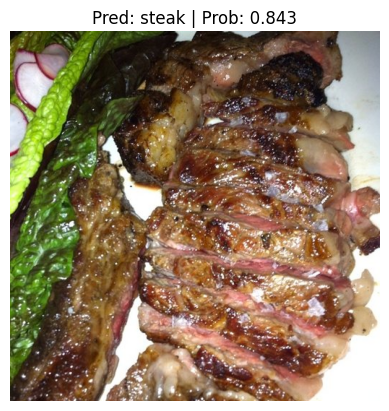

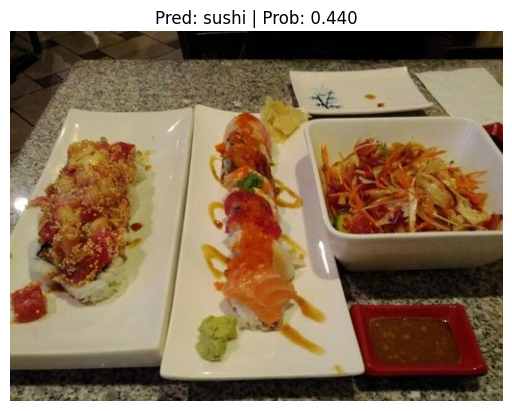

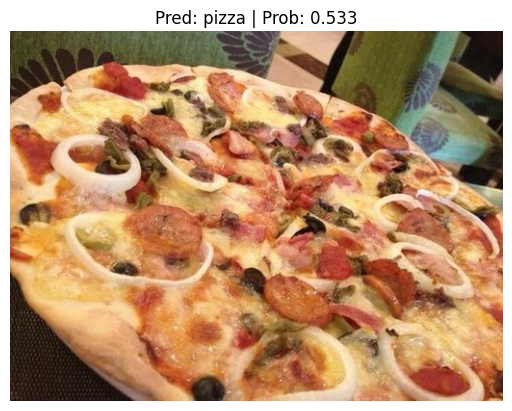

In [66]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=auto_transforms,
                        image_size=(224, 224))

# Making predictions on custom image

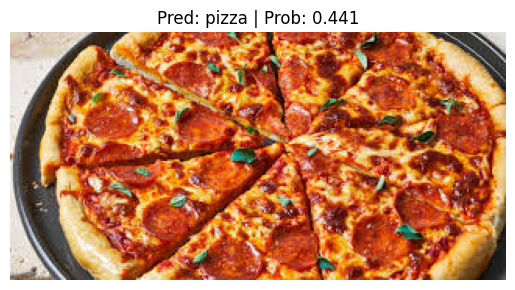

In [67]:
custom_image_path = "../pizza.png"

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

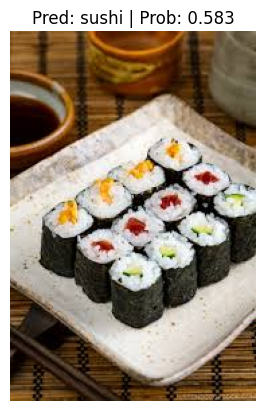

In [68]:
custom_image_path = "../sushi.png"

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)